In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import random

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'BertCleaned'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 0
LEARNING_RATE = 5e-05
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()

In [3]:
# model parameters
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

                

In [ ]:
# we set a seed ti get the sane weight initializzazion for the data prep validation
seed_val = 14
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
             PARAMS) 
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

In [ ]:
model = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE) 

In [7]:
model_analysis(model, val_df, LABEL_COLS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
out_cleaned = model.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
thresh_cleaned, _ = tune_sigmoid_threshold(target_cleaned, out_cleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)

## Goemotions:NoDataCleaning
We try to validate our datacleaning process training a bert model with vanilla tr-set

In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
MODEL_NAME = 'BertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# creating the model with the same seed as the cleaned version
seed_val = 14
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Bert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)
out_uncleaned = model_uncleaned.predict(val_df)
target_uncleaned = val_df.iloc[:, 1:].values
thresh_uncleaned, _ = tune_sigmoid_threshold(target_uncleaned, out_uncleaned, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {thresh_uncleaned}")
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
plot_score_barplot(target_uncleaned, best_out_uncleaned, LABEL_COLS)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 

Now we can compare the graphical results of the obtained models

In [5]:
_,val_df_uncleaned,_ = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
_,val_df,_ = load_dataset(DatasetEnum.GoEmotionsCleaned)
MODEL_NAME = 'Bert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)


PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

out_uncleaned = model_uncleaned.predict(val_df_uncleaned)
target_uncleaned = val_df_uncleaned.iloc[:, 1:].values
best_out_uncleaned = (out_uncleaned > thresh_uncleaned).astype(int)
   
out_cleaned = model_cleaned.predict(val_df)
target_cleaned = val_df.iloc[:, 1:].values
best_out_cleaned = (out_cleaned > thresh_cleaned).astype(int)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


NameError: name 'model_uncleaned' is not defined

C:\Users\gdema\AppData\Local\Temp\ipykernel_8748\2501826934.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


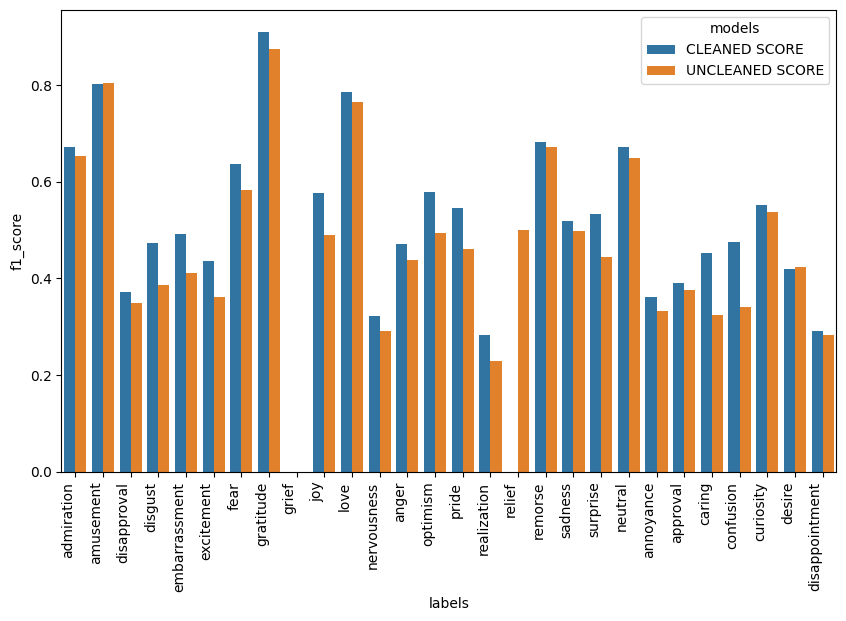

cleaned mean = 0.489169243740462
uncleaned mean = 0.46337629390048524


In [9]:

cleaned_score = f1_score(target_cleaned, best_out_cleaned,average=None)
uncleaned_score = f1_score(target_uncleaned, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")

# GO Emotions: 6 emotions
We can try to map the 27 emtions to Ekman standard and finetune a new model. <br>
We compare mapping first the dataset and then training the model with training the model and mapping the results to get the better alternative

### Post-training mapping
Si riallena il modello fissando dataset post shuffle e il seme per l'inizializzaizone dei pesi


In [4]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)
#we first shuffle the train-set
seed_val = 14
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

MODEL_NAME = 'Bert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':28
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model = Bert(SCORES,
                PARAMS) 

model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)
out = model.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold}")

#now we predìct to the test values and map the results
#first we map the test set
test_df = goemotions_apply_emotion_mapping(test_df)

out= model.predict(test_df)
target= test_df.iloc[:, 1:].values
best_out = (out> threshold).astype(int)



c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

Threshold = 0.27


F1-score = 0.6273125305872325


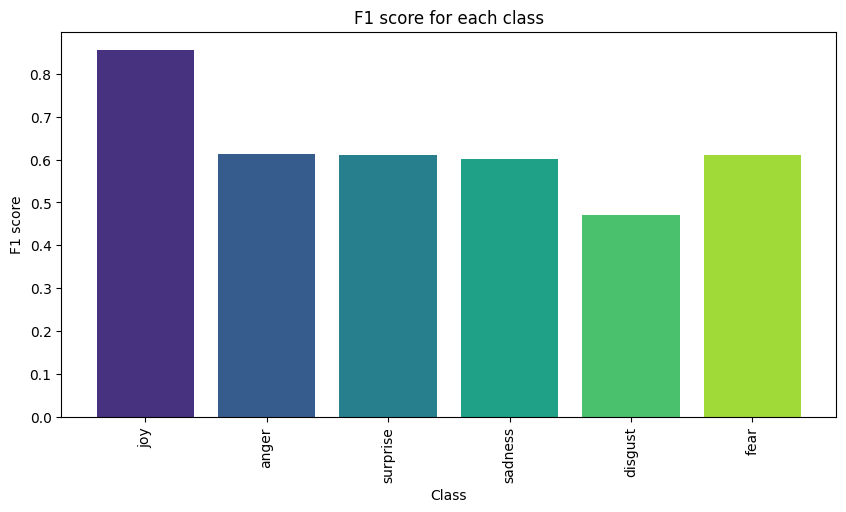

In [5]:
best_out=goemotions_apply_emotion_mapping(best_out,isDataframe=False)
score_postMap = f1_score(target, best_out,average=None)
plot_score_barplot(target, best_out,["joy","anger","surprise","sadness","disgust","fear"])
print (f"F1-score = {np.mean(score_postMap)}")

We expect to get a better results training with a mapped tr-set because we will drop the "neutral" entries, so we will not have all the predicted "neutral" entries automatically as a false positive because the model will not be able to classify the test entries with the neutral label

### Pre mapping training

In [3]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)
#we first shuffle the train-set
seed_val = 14
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_df=goemotions_apply_emotion_mapping(train_df)
val_df=goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)

CHECKPOINT_MODEL_FILE=CHECKPOINT_DIR + 'bert_model_preMapTraining.pth'
# creating the model with the same seed as the cleaned version
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':EPOCHS, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':6
}

SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}


model_preMap = Bert(SCORES,
                PARAMS) 

model_preMap.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)
out = model_preMap.predict(val_df)
target = val_df.iloc[:, 1:].values
threshold_premap, _ = tune_sigmoid_threshold(target, out, metric_params={'average':'macro', 'zero_division':0}, metric_fun=f1_score)
print(f"Threshold = {threshold_premap}")

out= model_preMap.predict(test_df)
target= test_df.iloc[:, 1:].values
best_out = (out> threshold_premap).astype(int)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1912 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Threshold = 0.23


F1-score = 0.659230304439934


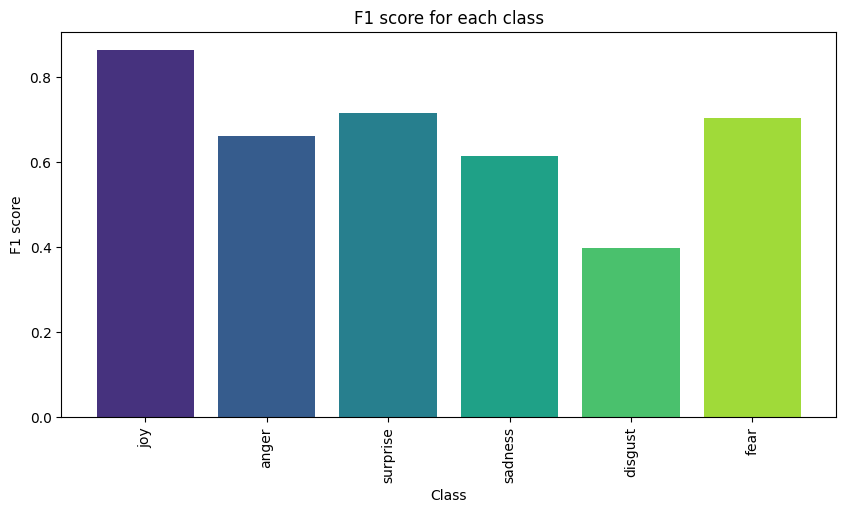

In [9]:
score_postMap = f1_score(target, best_out,average=None)
plot_score_barplot(target, best_out,["joy","anger","surprise","sadness","disgust","fear"])
print (f"F1-score = {np.mean(score_postMap)}")